Assignment 2 - K-Means Clustering<br>
Author: Thinh Le<br>
Date: February 4, 2025

# Introduction

Using the Python code provided by the Machine Learning in Action book (chapter 10), adapt the code to perform a K-Means Clustering on the Palmer Penguin dataset. Attempt to display a graph using the Elbow Method to determine an appropriate K. Document each step of the code to demonstrate you understand what each block of code does. Feel free to experiment with alternative measurements.

# Notes

- In this exercise, I will predict the number of penguins species by body mass and flipper length using the Elbow Method.
- The number of clusters (k) to test will be from 1 to 10.

# Solution

## Step 1: Import libraries

In [1]:
import pandas as pd             # Working with data
import numpy as np              # Working with arrays, vectors, lists
import matplotlib.pyplot as plt # Data visualization

Matplotlib is building the font cache; this may take a moment.


## Step 2: Read the dataset and extract flipper length and body mass data

First, read the dataset

In [2]:
# Read the Palmer Penguin cleaned dataset
# Note: place the dataset in the same folder with the jupyter notebook.
penguins_df = pd.read_csv('penguins_clean.csv')
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Drop NAs from the penguins_df

In [3]:
# Drop NAs from the penguins_df
penguins_df.dropna(inplace=True)
# inplace=True: Drop NAs from the penguins_df directly without creating a new variable to store the new df

Extract flipper length and body mass data from the `penguins_df`

In [4]:
# Extract flipper length and body mass from the penguins_df and assign it to a variable called points
points = penguins_df[['flipper_length_mm', 'body_mass_g']].to_numpy()
# Note: Same like points in 2D coordinate plane with a single point (x, y) = a single penguin (flipper length, body mass)

## Step 3: Create a function to create random initial cluster centroids

I want to to create random initial cluster centroids at the beginning.

First, find the min and max points. I do this to ensure that my initial cluster centroids stay within the min and max points of flipper length and body mass.

In [5]:
min_point = points.min(axis=0)
max_point = points.max(axis=0)
# Note: axis=0 is for searching value by column
# Example: [(2, 5), (1, 8)]: min_point is (1, 5) and max_point is (2, 8)

Create a function to create random initial cluster centroids within the data range

In [6]:
# Create random centroids within the data range
def create_random_centroids(
    _number_of_centroids,
    _number_of_coordinates
):
    # np.random.uniform(): Return random centroids within min and max range
    return np.random.uniform(
        min_point,
        max_point,
        # size: Define the number of centroids will be created with
        # corresponding coordinates (e.g. a point (x, y) has 2 coordinates)
        size=(_number_of_centroids, _number_of_coordinates)
    )

## Step 4: Create a function to calculate Euclidean distance

$$d(p, q) = \sqrt{\sum\limits_{i=1}^{n} (q_i - p_i)^2}$$
Markdown formula source: https://raw.githubusercontent.com/microsoft/semantic-kernel/refs/heads/main/docs/EUCLIDEAN_DISTANCE.md

In [7]:
# Calculate squared euclidean distance
# Ref: https://en.wikipedia.org/wiki/Euclidean_distance
def calculate_squared_euclidean_distance(_point1, _point2):
    # Note: convert _point1 and _point2 into numpy arrays
    point1 = np.array(_point1)
    point2 = np.array(_point2)
    # [4, 1] - [1, 5] = [4 - 1, 1 - 5] = [3, -4]
    point_subtraction = point1 - point2
    # [3, -4] ^ 2 = [3^2, -4^2] = [9, 16]
    squared_of_point_subtraction = point_subtraction ** 2
    # np.sum([9, 16]) = 25
    return np.sum(squared_of_point_subtraction)

# Calculate euclidean distance
def calculate_euclidean_distance(_point1, _point2):
    squared_euclidean_distance = calculate_squared_euclidean_distance(
        _point1,
        _point2
    )

    # sqrt(25) = 5
    return np.sqrt(squared_euclidean_distance)

## Step 5: Implement k-means clustering algorimth

1. Pick random points as initial cluster centers (centroids)
2. Assign each data point to the nearest centroid
3. Update the centroids
4. Repeat steps 3 and 4 until centroids don’t move

In [8]:
# k-means clustering algorithm
# This function receives
#   _points which is the flipper length and body mass data
#   _number_of_clusters is k
def kmeans_clustering(_points, _number_of_clusters):
    # Create random cluster centroids at the beginning
    centroids = create_random_centroids(
        _number_of_clusters,
        # The shape property returns the number of rows and columns (dimension),
        # pick the number of columns (1) as the number of coordinates
        points.shape[1]
    )

    # Create a list to track which point is assigned to which cluster
    #   _points.shape[0]: the number of points. Initialize all of them
    #   with -1 since they haven't been assigned to any cluster yet.
    point_centroid_indices = np.full(_points.shape[0], -1)

    while True:
        # Create a temporary mapper of point index and cluster centroid index
        # for each loop
        temp_point_centroid_indices = np.full_like(
            point_centroid_indices, -1
        )

        # For each point and its index in the _points data
        # enumerate(): help getting an index while looping
        for point_index, point in enumerate(_points):
            # Calculate the distance between the point and each centroid
            # using Euclidean distance formula
            distances = [
                calculate_euclidean_distance(point, centroid)
                for centroid in centroids
            ]
            # Get the cluster centroid index of the min distance
            # np.argmin() returns the index of the minimum distance from the
            # distances; this index also corresponds to the cluster centroid
            # index
            centroid_index = np.argmin(distances)
            # Assign the cluster index to the mapper at the point index
            temp_point_centroid_indices[point_index] \
                = centroid_index

        # Update cluster centroids
        new_centroids = np.zeros_like(centroids)
        
        # Loop through each cluster centroid index
        for centroid_index in range(_number_of_clusters):
            # If at least one point is mapped to this cluster centroid
            if np.any(
                temp_point_centroid_indices == centroid_index
            ):
                # Find all points assigned to this centroid
                filtered_points = points[
                    temp_point_centroid_indices == centroid_index
                ]
                # Update the centroid by calculating mean of all points assigned
                # to it
                # axis=0: calculate mean by column
                new_centroids[centroid_index] = np.mean(filtered_points, axis=0)
                # E.g. Mean of [[1, 2]
                #               [5, 6]] is [(1 + 5) /2, (2 + 6) / 2] = [3, 4]

                # Note: This will move the cluster centroid to a new location
                # closer to all the points assigned to it.
            # Some cluster centroids may have no points assigned to them.
            else:
                # Keep old centroid if no points assigned
                new_centroids[centroid_index] = centroids[centroid_index]

        # After updating all the centroids, stop if centroids do not change
        # np.allclose(): compare if two arrays are approximately equal
        # E.g. [1.0, 2.0, 3.0] == [1.00001, 2.00001, 3.00001] - True
        if np.allclose(centroids, new_centroids):
            break

        # Else
        # Update the centroids
        centroids = new_centroids
        # Update the main mapper
        point_centroid_indices = temp_point_centroid_indices

    return centroids, point_centroid_indices

## Step 6: Create a function to calculate the with-in cluster sum of squares (WCSS)

In [9]:
# wcss: with-in cluster sum of squares
def calculate_total_wcss(_points, _number_of_clusters):
    centroids, point_centroid_indices = kmeans_clustering(
        _points, _number_of_clusters
    )

    total_wcss = 0.0

    # For each point and its index in the _points data
    for point_index, point in enumerate(_points):
        # Find the centroid index for point_index
        centroid_index = point_centroid_indices[point_index]
        # Get the corresponding centroid
        centroid = centroids[centroid_index]
        # Calculate squared euclidean distance
        squared_euclidean_distance = calculate_squared_euclidean_distance(
            point,
            centroid
        )
        # Add to the total_wcss
        total_wcss += squared_euclidean_distance

    return total_wcss

## Step 7: Calculate total WCSS for each number of clusters (k)

In [10]:
# Define a range for the number of clusters (k)
# From 1 to 10
number_of_clusters_range = range(1, 11)
# Calculate total with-in cluster sum of squares for each number of clusters
wcss_values = [
    calculate_total_wcss(points, number_of_clusters)
    for number_of_clusters in number_of_clusters_range
]

## Step 8: Plot the Elbow Method graph

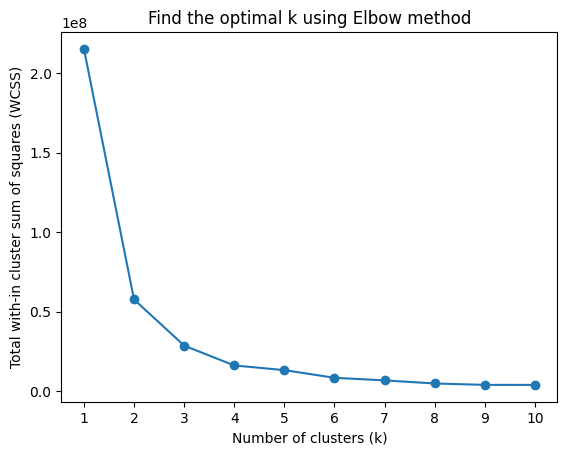

In [11]:
# x: number of clusters (k) from 1 - 10
# y: calculated total wcss for each k
# marker: circle
# line style: solid line
plt.plot(number_of_clusters_range, wcss_values, marker='o', linestyle='-')
# Graph title
plt.title('Find the optimal k using Elbow method')
# x-axis title
plt.xlabel('Number of clusters (k)')
# y-axis title
plt.ylabel('Total with-in cluster sum of squares (WCSS)')
# Set ticks from 1 to 10 with step 1
plt.xticks(np.arange(1, 11, 1))
# Show the graph
plt.show()

We can see that k = 3 is the "elbow point", where the total WCSS stops decreasing sharply.